## Sample script to learn a PDE parameter in training

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from torchphysics.problem import Variable, Parameter
from torchphysics.setting import Setting
from torchphysics.problem.domain import (Rectangle,
                                           Interval)
from torchphysics.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import laplacian, grad
from torchphysics.utils.fdm import FDM, create_validation_data
from torchphysics.utils.plot import Plotter
from torchphysics.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()


/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


True

We define some parameters that describe the setting:

In [2]:
w, h = 10, 10
t0, tend = 0, 3
temp_hot = 100

We define the independent variables of the PDE, which will later determine the inputs to the NN. Every variable has a domain and can have one or more boundary conditions.

Now we also define a Parameter which will be optimized during training, based on given training data.

In [3]:
x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[w, 0],
                              corner_tl=[0, h]),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

m = torch.Tensor((5.0,))
D = Parameter(init=m, name='D')

Using the same notation, as in the forward problem, we can define a PDE-condition to the inner of the domain.

Here we also include the parameter 'D' in the (dummy) equation, that should be computed. Therefore the pde-condition gets now an additional input: params. This input contains all learnable paramters of the model.

In [4]:
norm = torch.nn.MSELoss()

def pde(u, **input):
    return grad(u, input['t']) - input['D']*laplacian(u, input['x'])

train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             sampling_strategy='random',
                             weight=1.0,
                             dataset_size=500,
                             data_plot_variables=('x','t'))

def x_dirichlet_fun(x):
    return 0

x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         whole_batch=False,
                                         name='dirichlet',
                                         sampling_strategy='random',
                                         boundary_sampling_strategy='random',
                                         norm=norm,
                                         weight=1.0,
                                         dataset_size=500,
                                         data_plot_variables=('x','t')))

Instead of adding addtional conditions for the inital and boundary values we now create a DataCondition, by using a FDM to solve the forward problem.

In [5]:
D_list = [2] # This D is the value we will later try to find!
domain_dic = {'x': [[0,w], [0,h]]}
dx, dy = 0.5, 0.5
step_width_dict = {'x': [dx, dy]}
time_interval = [t0, tend]
def inital_condition(**input):
    return temp_hot * np.sin(np.pi/w*input['x'][0]) * np.sin(np.pi/h*input['x'][1]) 
fdm_start = timer()
domain, time, u = FDM(domain_dic, step_width_dict, time_interval, 
                      D_list, inital_condition)
fdm_end = timer()
print('Time for FDM-Solution:', fdm_end-fdm_start)

data_x, data_u = create_validation_data(domain, time, u, D_list, D_is_input = False)

Time for FDM-Solution: 0.03629172779619694


We dont want to use all points of the FDM-solution, therefore for now pick only 5000 random values 

In [6]:
index = np.random.choice(len(data_u), 5, replace=False)
data_u = data_u[index]
for name in data_x:
    data_x[name] = data_x[name][index]

With these points we now create a DataCondition

In [7]:
data_cond = DataCondition(data_x=data_x,
                         data_u=data_u,
                         name='data_cond',
                         norm=norm)

As always the variables as well as the conditions for the inner part of the domain are collected in a Setting. Now we also add the parameters that should be trained in a dictonary:

In [8]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond, 'data': data_cond},
                val_conditions={},
                n_iterations=500,
                parameters={'D': D})

To solve the problem we use (like always) the PINNModule 

In [9]:
solver = PINNModule(model=SimpleFCN(input_dim=3, depth=3, width=20),
                    optimizer=torch.optim.Adam, # Start with adam
                    lr=1e-2
                    )

Finally, we define a lightning trainer and train the model. 

In [10]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     logger=False,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=1,
                     max_epochs=4,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
Epoch 3: 100%|██████████| 500/500 [00:10<00:00, 47.04it/s, loss=0.345]


In [11]:
setup.parameters['D']

Parameter containing:
tensor([0.4838], device='cuda:0', requires_grad=True)

In [13]:
# switch to lbfgs
solver.lr = 0.05
solver.optim_params = {'max_iter': 1, 'history_size': 100}
solver.optimizer = torch.optim.LBFGS
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     logger=False,
                     check_val_every_n_epoch=100,
                     log_every_n_steps=100,
                     max_epochs=3,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
Epoch 2: 100%|██████████| 500/500 [00:18<00:00, 27.43it/s, loss=0.0383]


And again check the value of D. It is pretty close to D = 2, what we used in the FDM 

In [14]:
setup.parameters['D']

Parameter containing:
tensor([0.2102], device='cuda:0', requires_grad=True)

Not only did we find D, the neural network also learned the solution of our problem:

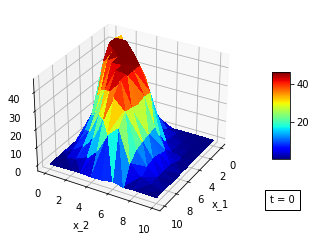

In [15]:
from torchphysics.utils.plot import _plot
fig = _plot(solver.model, plot_variables=x, points=100, dic_for_other_variables={'t': 0})